# Replace star sampling with sampling ranges of L M and T

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform
plt.style.use('paper')
from swarms import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON

In [2]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [3]:
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [4]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_sampler(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    # Table 1 (KALTENEGGER & TRAUB) https://arxiv.org/ftp/arxiv/papers/0903/0903.3371.pdf
    ML = [7.2/100., 3.5/100., 2.3/100., 1.5/100., 0.55/100., 0.22/100., 0.09/100., 0.05/100., 0.03/100., 0.015/100.]
    MM = [0.60, 0.49, 0.44, 0.36, 0.20, 0.14, 0.10, 0.09, 0.08, 0.075]
    MT = [3800, 3600, 3400, 3250, 3100, 2800, 2600, 2500, 2400, 2300]
    sample = -1
    while sample < 0 or sample > 9:
        sample = int(random.normal(loc=mean, scale=std))
    
    return swarms.Star(M=MM[sample]*MSUN, L=ML[sample]*LSUN, T=MT[sample], d=0) # M star

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 20 # Mearth (just over Nep. Lowest val in Baraffe)
    Mmax = 5*318 # Mearth (5 MJup. Highest in Baraffe)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/PC*IWA# AU
        amax = star.d/PC*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler2():
    y = uniform(0, 1)
    return inverse_cdf(y)*1e6 * YEAR

def age_sampler():
    return loguniform(1.1e7, 1e8) * YEAR

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

# Sample

In [5]:
IWA = 0.2 # arcseconds
OWA = 1.2
MWA = (IWA + OWA)/2
lamb = 1.65 * MICRON

M0 = 1*MEARTH
aopt = 200 # AU
dopt = aopt/MWA * PC
print('Optimal Distance = {0:.0f} pc'.format(dopt/PC))

Optimal Distance = 286 pc


In [6]:
def sample(M0, dopt, lamb, star_type):
    if star_type == "G2":
        star = swarms.Star(1.*LSUN, 1.*MSUN, 5780, d=0)
    elif star_type == "M0":
        star = swarms.Star(0.072*LSUN, 0.60*MSUN, 3800, d=0)
    elif star_type == "K5":
        star = swarms.Star(0.16*LSUN, 0.69*MSUN, 4410, d=0)
    elif star_type == "G5":
        star = swarms.Star(0.79*LSUN, 0.93*MSUN, 5610, d=0)
    elif star_type == "F5":
        star = swarms.Star(2.5*LSUN, 1.3*MSUN, 6540, d=0)
    elif star_type == "F0":
        star = swarms.Star(5.2*LSUN, 1.4*MSUN, 7420, d=0)
    else:
        print("randomizing")
        star = star_sampler()
    star.d = distance_sampler(mean=dopt, std=dopt/2.)
    if star.Imag < 0 or star.Imag > 12:
        print(star.Imag)
        return sample(M0, dopt, lamb, star_type) # do it again
    age = age_sampler()
    
    planet = draw_planet(star, age=age)
    if planet is None:
        return sample(M0, dopt, lamb, star_type) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = uniform(0.2, 0.4) # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    CRscatSwarm = swarm.computeCRscat(g)
    CRscatPlanet = planet.computeCRscat(g)
    CRthermalPlanet = planet.computeCRthermal(lamb)
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/PC, planet.M, star.Imag

In [7]:
%%time
seed(0)
M1 = 1*MEARTH
dopt1 = 200 * PC
star_type1 = "G5"
Nsamples = 300
CRscatSwarm1, CRPlanet1, a1, d1, Mplt1, Imag1 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm1[i], CRPlanet1[i], a1[i], d1[i], Mplt1[i], Imag1[i] = sample(M1, dopt1, lamb, star_type1)

12.18329847288232
12.482690973815435
12.127300651394524
12.386087433691399
12.402972175998595
12.223105864000427
12.582017194448035
12.016701143162894
12.354340444607626
12.466812263382552
12.217435878282462
12.179940085655534
12.387818274198267
12.320763981556006
12.797133594776236
12.658672622079688
12.21317445405723
12.197273899344811
12.273841059773314
12.361724912015003
12.173334908508284
12.126143072710384
12.189302519694099
12.617000787699244
12.28524595179798
12.031581350860701
12.059351562354713
12.091927115007353
12.218488613282002
12.698203349917314
12.156848131375993
12.106272971744279
12.052987877727686
12.008009956551112
12.243044063549409
12.356618492498804
12.01610532960143
12.631639083465663
12.399362518625782
12.152149145811551
12.107603344507652
12.548753751516099
12.222638992425342
CPU times: user 13.6 s, sys: 1.02 s, total: 14.7 s
Wall time: 14.7 s


In [8]:
%%time
seed(0)
M2 = 0.01*MEARTH
dopt2 = 55 * PC
star_type2 = "M0"
Nsamples = 300
CRscatSwarm2, CRPlanet2, a2, d2, Mplt2, Imag2 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm2[i], CRPlanet2[i], a2[i], d2[i], Mplt2[i], Imag2[i] = sample(M2, dopt2, lamb, star_type2)

12.350251273995811
12.223781549326613
12.280791178407778
12.04826827306147
12.26667920447467
12.050003458801042
12.185578742158816
12.17790760215308
12.431822829487762
12.031779034620438
12.132143321170254
CPU times: user 13.2 s, sys: 957 ms, total: 14.2 s
Wall time: 14.2 s


In [9]:
%%time
seed(0)
M4 = 1.e-4*MEARTH
star_type4 = "M0"
dopt4 = 15 * PC
Nsamples = 300
CRscatSwarm4, CRPlanet4, a4, d4, Mplt4, Imag4 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm4[i], CRPlanet4[i], a4[i], d4[i], Mplt4[i], Imag4[i] = sample(M4, dopt4, lamb, star_type4)

-4.596253403634767
CPU times: user 13.2 s, sys: 968 ms, total: 14.2 s
Wall time: 14.2 s


In [10]:
%%time
seed(0)
M6 = 1.e-6*MEARTH
dopt6 = 3.5 * PC
star_type6 = "M0"
Nsamples = 300
CRscatSwarm6, CRPlanet6, a6, d6, Mplt6, Imag6 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm6[i], CRPlanet6[i], a6[i], d6[i], Mplt6[i], Imag6[i] = sample(M6, dopt6, lamb, star_type6)

-7.355105611965417
-1.104722035651052
-0.31959295222063455
-2.6495190653851304
CPU times: user 13.1 s, sys: 951 ms, total: 14 s
Wall time: 14 s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


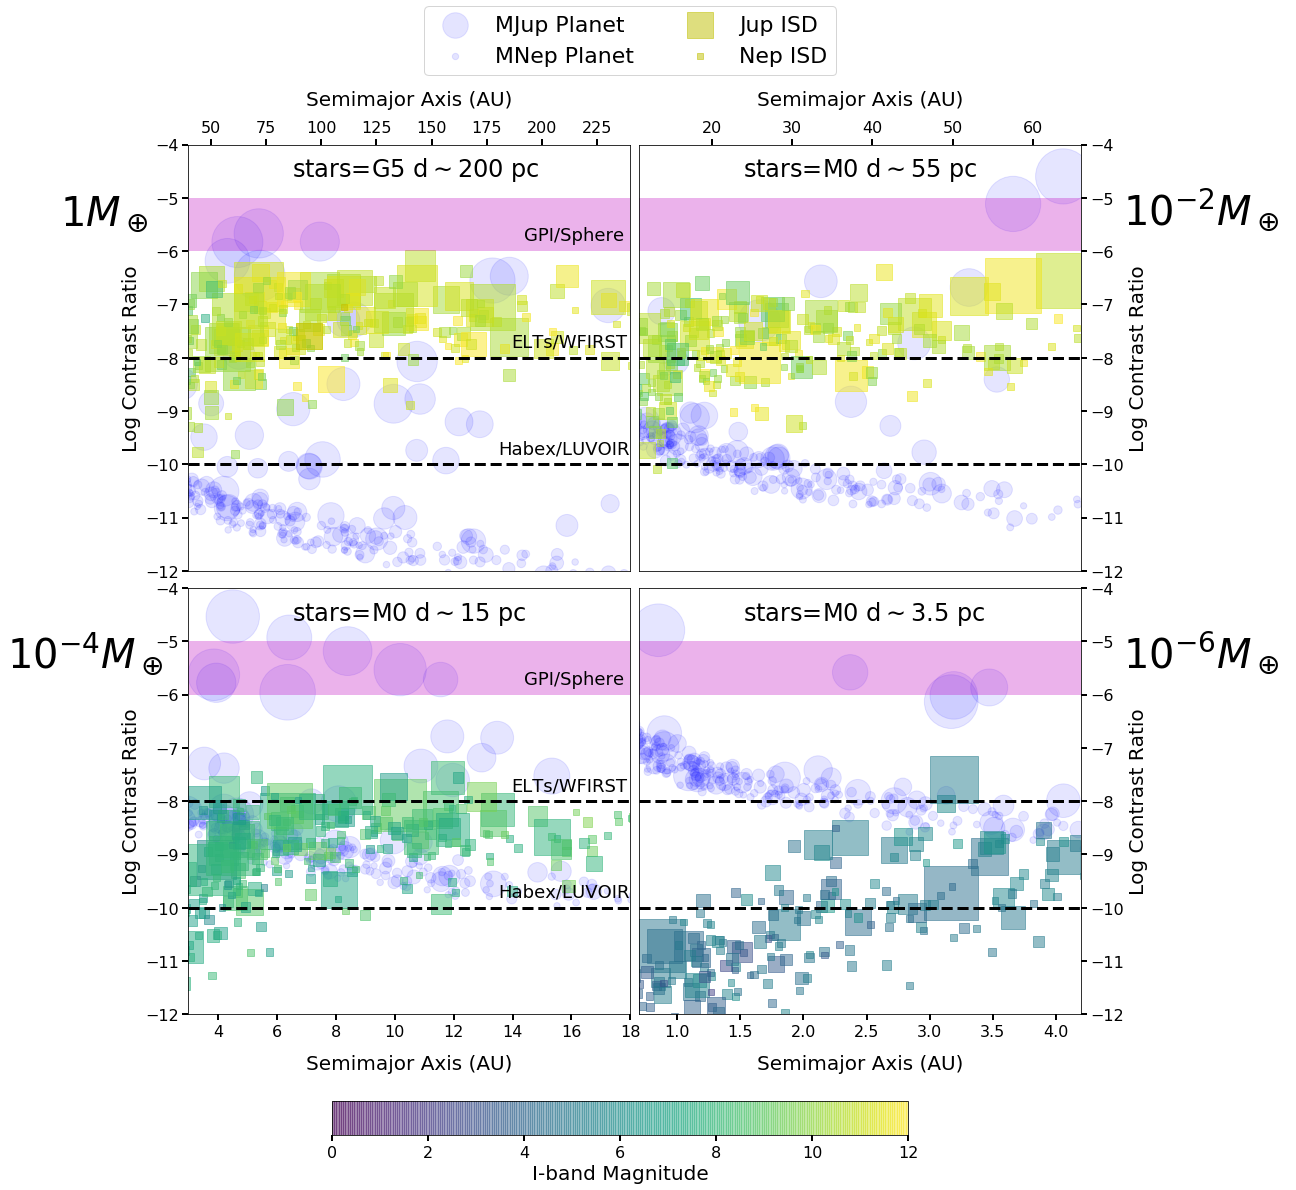

In [123]:
def plot(ax, a, logCRscatSwarm, logCRPlanet, Mplt, Imag, dopt):
    Mcut = 2*Mplt/MEARTH
    ax.scatter(a, logCRPlanet, c='b', vmax=12, vmin=0, s=Mcut, alpha=0.1, marker='o')
    sc = ax.scatter(a, logCRscatSwarm, c=Imag, vmax=12, vmin=0, s=Mcut, alpha=0.5, marker='s')
    ax.axhline(-8, color='k', linestyle='--')
    ax.axhline(-10, color='k', linestyle='--')
    
    ax.set_xlim([IWA*dopt/PC, OWA*dopt/PC])
    ax.set_ylim([-12, -4])
    ax.set_ylabel('Log Contrast Ratio')
    ax.set_xlabel('Semimajor Axis (AU)', labelpad=15)
    mn, mx = ax.get_xlim()
    ax.fill_between(np.linspace(mn, mx, 10), -6, -5, facecolor='m', alpha=0.3)
    return sc

plt.style.use('paper')
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, figsize=(16,16))
cm = plt.cm.get_cmap('RdYlBu')
plt.subplots_adjust(wspace=0.02, hspace=0.04)

sc = plot(axs[0,0], a1, np.log10(CRscatSwarm1), np.log10(CRPlanet1), Mplt1, Imag1, dopt1)
sc = plot(axs[0,1], a2, np.log10(CRscatSwarm2), np.log10(CRPlanet2), Mplt2, Imag2, dopt2)
sc = plot(axs[1,0], a4, np.log10(CRscatSwarm4), np.log10(CRPlanet4), Mplt4, Imag4, dopt4)
sc = plot(axs[1,1], a6, np.log10(CRscatSwarm6), np.log10(CRPlanet6), Mplt6, Imag6, dopt6)

#fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)

s=0.9
axs[0,0].text(192, -5.8, "GPI/Sphere", color='k', fontsize=18)
axs[0,0].text(186, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axs[0,0].text(180, -9.8, "Habex/LUVOIR", color='k', fontsize=18)

axs[1,0].text(14.4, -5.8, "GPI/Sphere", color='k', fontsize=18)
axs[1,0].text(13.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axs[1,0].text(13.5, -9.8, "Habex/LUVOIR", color='k', fontsize=18)

axs[0,0].xaxis.set_label_position("top")
axs[0,0].xaxis.tick_top()
axs[0,1].xaxis.set_label_position("top")
axs[0,1].xaxis.tick_top()

axs[0,1].yaxis.set_label_position("right")
axs[0,1].yaxis.tick_right()
axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()

ax = axs[0,0]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=G5 d$\sim$200 pc", fontsize=24)
ax.text(-0.13*avg, -5.5, r"$1M_\oplus$ ", fontsize=40)
ax = axs[0,1]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$55 pc", fontsize=24)
ax.text(1.85*avg, -5.5, r"$10^{-2}M_\oplus$ ", fontsize=40)
ax = axs[1,0]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$15 pc", fontsize=24)
ax.text(-0.3*avg, -5.5, r"$10^{-4}M_\oplus$ ", fontsize=40)
ax = axs[1,1]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$3.5 pc", fontsize=24)
ax.text(1.85*avg, -5.5, r"$10^{-6}M_\oplus$ ", fontsize=40)

Mcut1 = 2*Mplt1/MEARTH
Jupmask = np.abs(Mplt1/MEARTH - 318) < 30
Nepmask = np.abs(Mplt1/MEARTH - 20) < 1
sc1 = axs[0,0].scatter(a1[Jupmask][0], np.log10(CRPlanet1)[Jupmask][0], c='b', vmax=12, vmin=0, s=Mcut1[Jupmask][0], alpha=0.1, marker='o', label="MJup Planet")
sc2 = axs[0,0].scatter(a1[Nepmask][0], np.log10(CRPlanet1)[Nepmask][0], c='b', vmax=12, vmin=0, s=Mcut1[Nepmask][0], alpha=0.1, marker='o', label="MNep Planet")
sc3 = axs[0,0].scatter(a1[Jupmask][0], np.log10(CRscatSwarm1)[Jupmask][0], c='y', vmax=12, vmin=0, s=Mcut1[Jupmask][0], alpha=0.5, marker='s', label="Jup ISD")
sc4 = axs[0,0].scatter(a1[Nepmask][0], np.log10(CRscatSwarm1)[Nepmask][0], c='y', vmax=12, vmin=0, s=Mcut1[Nepmask][0], alpha=0.5, marker='s', label="Nep ISD")

axs[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=2, fontsize=22)

cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
cbar = fig.colorbar(sc, cax=cb_ax, orientation='horizontal', label='I-band Magnitude')

#plt.colorbar(sc, orientation='horizontal')